# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from Levenshtein import distance
from datetime import datetime as dt

try:
    data = pd.read_csv(r"C:\Users\yka\Documents\Practicum\DS_Practicum\Real_Estate_Price_Prediction\source\real_estate_data.csv", sep='\t', header=0)
except:
    data = pd.read_csv("/datasets/real_estate_data.csv", sep='\t', header=0)

pd.set_option('display.max_columns', None)
data.head(20)


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,False,False,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,False,False,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,False,False,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,False,False,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,False,False,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,False,False,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,False,False,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,False,False,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,False,False,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Так как данные занимают отностиельно мало места в памяти, нет смысла в оптимизации типов данных.

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

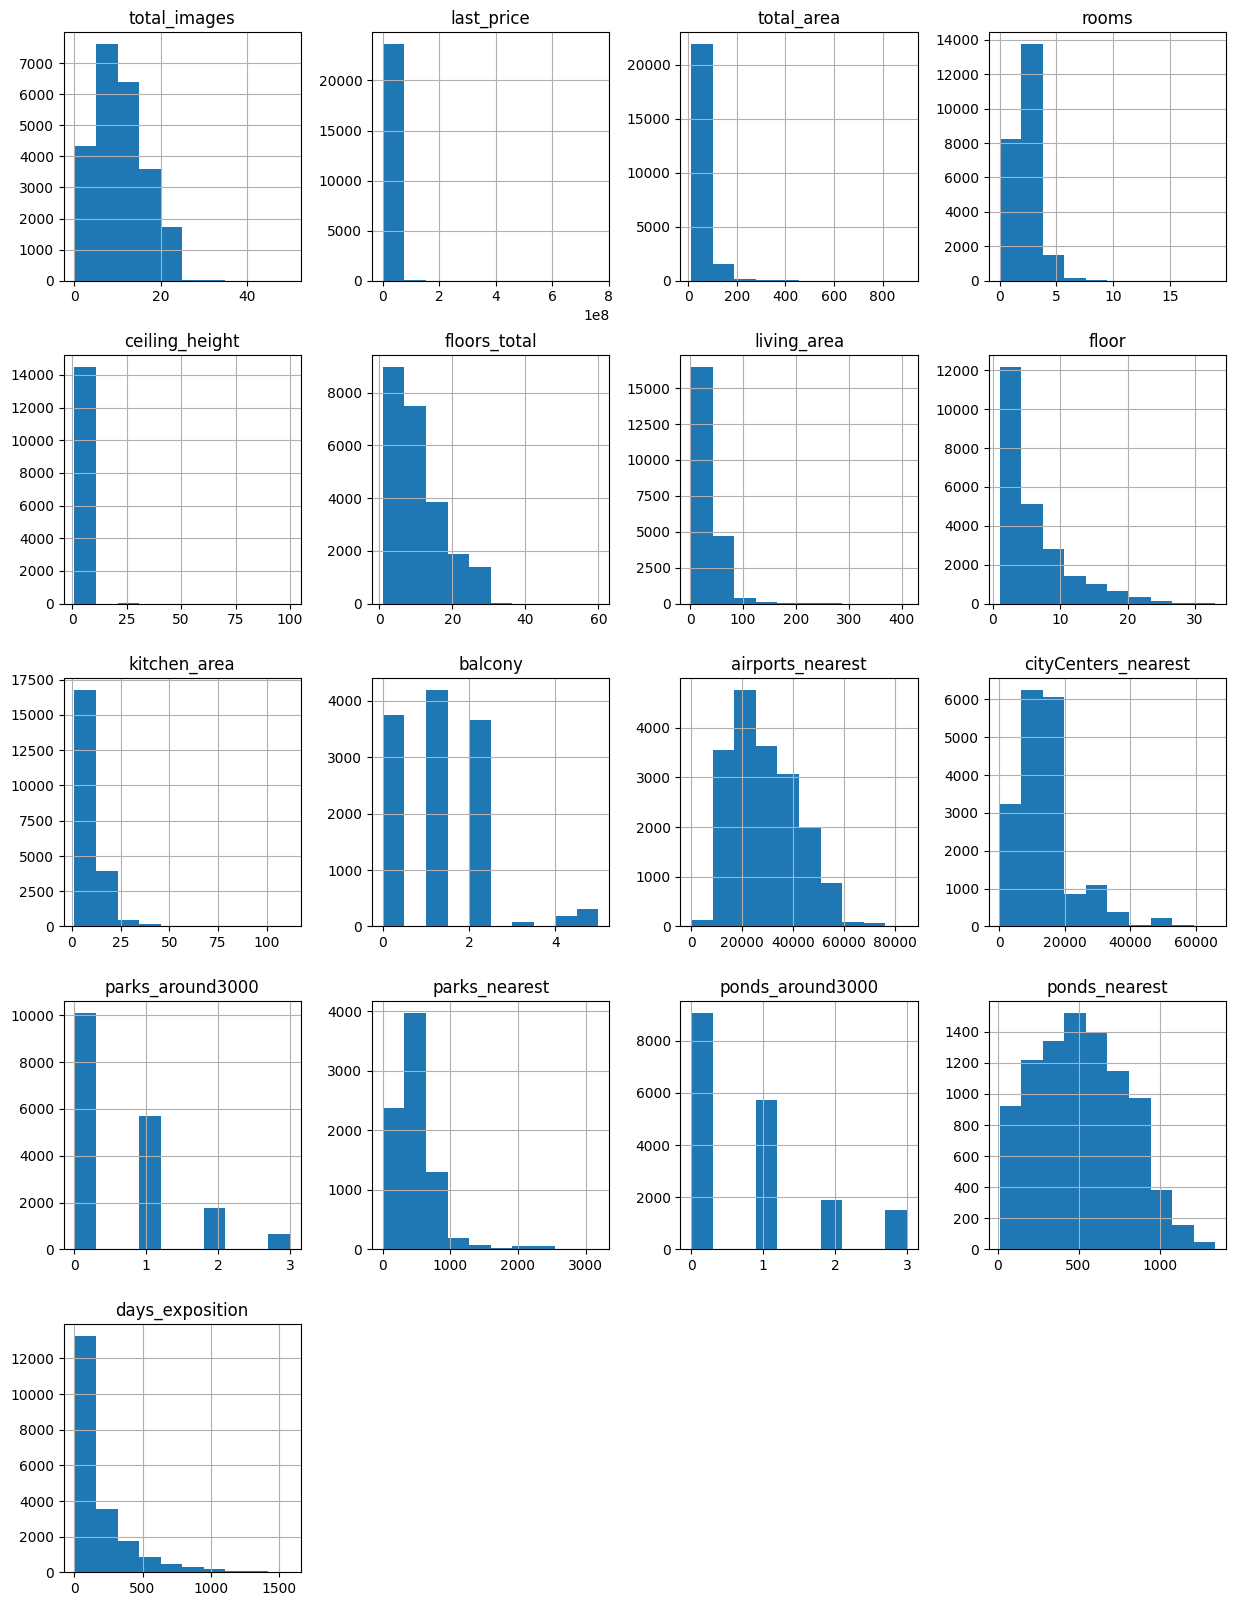

In [3]:
data.hist(figsize=(15, 20))

### Выполните предобработку данных

In [4]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Для понимания того, какие пропуски сильно влияют на цену рассмотрим корреляции.

In [5]:
data.corr()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_images,1.000000,0.104473,0.115352,0.099288,-0.001987,0.010427,0.104780,0.031340,-0.029303,-0.024407,0.104756,0.121693,-0.002298,-0.047666,0.021120,-0.008347,-0.011553,-0.003034,-0.026657
last_price,0.104473,1.000000,0.653675,0.363343,0.085430,-0.006984,0.566492,0.026576,-0.025362,-0.008802,0.519869,0.029646,-0.026239,-0.206747,0.151058,-0.016414,0.159996,-0.084809,0.081146
total_area,0.115352,0.653675,1.000000,0.758344,0.095490,-0.075774,0.939537,-0.024754,-0.072653,-0.034885,0.609121,0.047937,-0.030753,-0.231446,0.164689,-0.021497,0.162346,-0.097969,0.149675
rooms,0.099288,0.363343,0.758344,1.000000,0.054457,-0.228215,0.845977,-0.150862,-0.147286,-0.087500,0.269945,0.017991,-0.061199,-0.184864,0.137257,-0.054549,0.092693,-0.057689,0.126961
ceiling_height,-0.001987,0.085430,0.095490,0.054457,1.000000,-0.028732,0.090650,-0.011798,0.001674,0.042777,0.087641,0.040523,-0.023947,-0.091689,0.065915,-0.019167,0.078209,-0.059090,0.019091
floors_total,0.010427,-0.006984,-0.075774,-0.228215,-0.028732,1.000000,-0.169311,0.678059,0.070151,0.050791,0.163944,0.194065,0.108288,0.019774,-0.252833,0.097527,-0.122735,0.038864,-0.052234
living_area,0.104780,0.566492,0.939537,0.845977,0.090650,-0.169311,1.000000,-0.097210,-0.056231,-0.033711,0.428674,0.018849,-0.057912,-0.231368,0.184453,-0.050167,0.148933,-0.081674,0.142454
floor,0.031340,0.026576,-0.024754,-0.150862,-0.011798,0.678059,-0.097210,1.000000,0.036940,0.035824,0.135531,0.168773,0.071597,0.009084,-0.163784,0.073045,-0.076312,0.024850,-0.039463
studio,-0.029303,-0.025362,-0.072653,-0.147286,0.001674,0.070151,-0.056231,0.036940,1.000000,-0.004235,NaN,0.031455,-0.021876,-0.007029,-0.030202,0.009134,0.000939,0.002606,-0.022476
open_plan,-0.024407,-0.008802,-0.034885,-0.087500,0.042777,0.050791,-0.033711,0.035824,-0.004235,1.000000,NaN,0.019491,-0.013583,-0.004204,-0.010077,0.010612,0.008455,-0.003328,-0.024112


<AxesSubplot:>

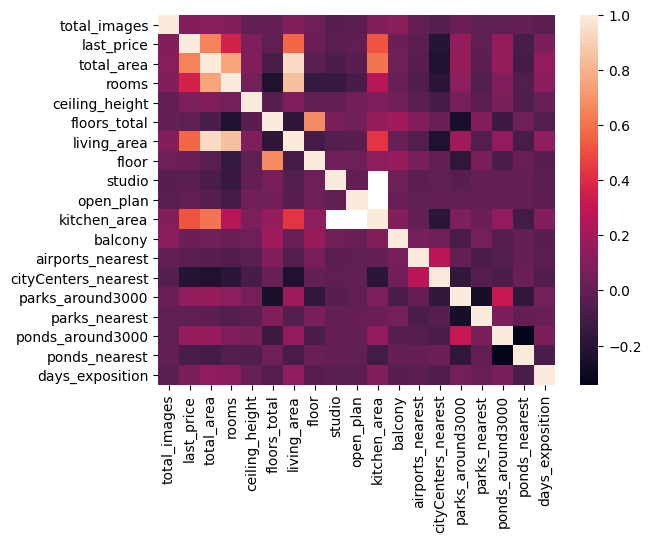

In [6]:
sb.heatmap(data.corr())

Примим решение по обработке пропусков для кажлого из соответствующих столбцов. Начнём с атрибутов данных, которые незначительно влияют на цену.

(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.100e+01, 0.000e+00, 6.000e+00, 4.100e+01, 5.089e+03,
        4.166e+03, 2.281e+03, 2.660e+02, 1.460e+03, 4.200e+02, 2.100e+02,
        2.550e+02, 8.200e+01, 4.700e+01, 4.400e+01, 4.900e+01, 7.000e+00,
        1.200e+01, 6.000e+00, 7.000e+00, 3.000e+00, 1.000e+00, 2.000e+00]),
 array([1.        , 1.13333333, 1.26666667, 1.4       , 1.53333333,
        1.66666667, 1.8       , 1.93333333, 2.06666667, 2.2       ,
        2.33333333, 2.46666667, 2.6       , 2.73333333, 2.86666667,
        3.        , 3.13333333, 3.26666667, 3.4       , 3.53333333,
        3.66666667, 3.8       , 3.93333333, 4.06666667, 4.2       ,
        4.33333333, 4.46666667, 4.6       , 4.73333333, 4.86666667,
        5.        ]),
 <BarContainer object of 30 artists>)

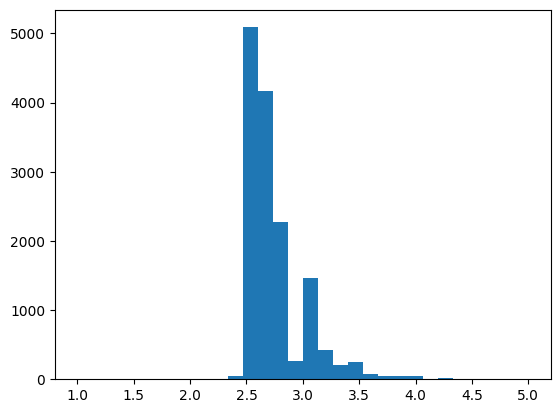

In [7]:
plt.hist(data["ceiling_height"], bins=30, range=(1, 5))

In [8]:
data["ceiling_height"].corr(data["last_price"])

0.085430309828426

Учитывая график распределения высоты потолков с длинным хвостом в сторону высоких потолков и относительно низкую корреляцию с ценой, заменим пропуски медианным значением как наиболее типичным без риска исказить целевой показатель предсказания.

In [9]:
data["ceiling_height"] = data["ceiling_height"].fillna(value=data["ceiling_height"].median())
data["ceiling_height"].isna().sum()

0

(array([2.500e+01, 3.830e+02, 6.680e+02, 6.988e+03, 9.140e+02, 5.920e+02,
        4.151e+03, 1.174e+03, 2.030e+02, 1.591e+03, 5.530e+02, 3.650e+02,
        2.209e+03, 5.050e+02, 3.390e+02, 4.290e+02, 2.860e+02, 3.520e+02,
        1.544e+03, 1.240e+02, 1.640e+02, 2.200e+01, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 2.400e+01, 4.000e+00, 0.000e+00, 0.000e+00]),
 array([ 0.        ,  1.33333333,  2.66666667,  4.        ,  5.33333333,
         6.66666667,  8.        ,  9.33333333, 10.66666667, 12.        ,
        13.33333333, 14.66666667, 16.        , 17.33333333, 18.66666667,
        20.        , 21.33333333, 22.66666667, 24.        , 25.33333333,
        26.66666667, 28.        , 29.33333333, 30.66666667, 32.        ,
        33.33333333, 34.66666667, 36.        , 37.33333333, 38.66666667,
        40.        ]),
 <BarContainer object of 30 artists>)

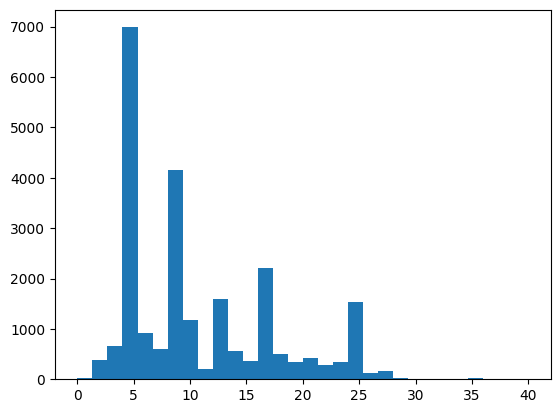

In [10]:
plt.hist(data["floors_total"], bins=30, range=(0, 40))

In [11]:
data["floors_total"].corr(data["last_price"])

-0.006983534007227376

Учитывая график распределения этажности здания с хвостами, несколькими локальными максимумами и относительно низкую корреляцию с ценой, заменим пропуски средним арифметическим значением чтобы не искажать дисперсию.

In [12]:
data["floors_total"] = data["floors_total"].fillna(value=data["floors_total"].mean())
data["floors_total"].isna().sum()

0

Рассмотрим пропуски в поле `is_apartment`. Их подозрительно много. Пропуски почти во всех записях.

In [13]:
data["is_apartment"].isna().sum()

20924

In [14]:
data["is_apartment"].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Т.к. апартаментов в присутствующих данных очень мало предположим, что во всех записях пропуски обозначают, что недвижимость не является апартаментами.

In [15]:
data["is_apartment"] = data["is_apartment"].fillna(value=False)
data["is_apartment"].value_counts()

False    23649
True        50
Name: is_apartment, dtype: int64

Рассмотрим пропуски в поле `is_apartment`. Пропуски почти в половине записей.

In [16]:
data["balcony"].isna().sum()

11519

In [17]:
data["balcony"].value_counts()

1.0    4195
0.0    3758
2.0    3659
5.0     304
4.0     183
3.0      81
Name: balcony, dtype: int64

Предположим, что в записях с пропусками нет балконов т.к. продавец замотивирован указывать преимущества в своём объявлений и пропуск может означать отсутствие.

In [18]:
data["balcony"] = data["balcony"].fillna(value=0)
data["balcony"].value_counts()

0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
Name: balcony, dtype: int64

Рассмотрим пропуски в поле `locality_name`. Т.к. из названия поля не ясно, что значит эта строка, посмотрим на значения и их количество

In [19]:
data["locality_name"].isna().sum()

49

In [20]:
data["locality_name"].value_counts()

Санкт-Петербург            15721
посёлок Мурино               522
посёлок Шушары               440
Всеволожск                   398
Пушкин                       369
                           ...  
деревня Вахнова Кара           1
деревня Борисова Грива         1
деревня Малая Романовка        1
деревня Хапо-Ое                1
поселок Калитино               1
Name: locality_name, Length: 364, dtype: int64

Поле означает название населённого пункта. Предположим, что в значениях этого поля могут быть явные и неявные дубликаты и проверим это позже. На данном этапе заполним пропуски строками "No locality" т.к. значение может быть в дальнейшем использовано для группировки по категории населённых пунктов.

In [21]:
data["locality_name"] = data["locality_name"].fillna(value="No locality")
data["locality_name"].isna().sum()

0

Поле `airports_nearest` не очень скоррелировано с прогнозируемым показателем, поэтому посмотрим на частотность встречаемых значений и примем решение исходя их неё.

In [22]:
data["airports_nearest"].isna().sum()

5542

(array([1.000e+00, 2.000e+00, 3.070e+02, 1.444e+03, 1.825e+03, 1.794e+03,
        1.724e+03, 1.959e+03, 1.304e+03, 1.392e+03, 1.583e+03, 1.247e+03,
        8.570e+02, 8.420e+02, 6.580e+02, 6.950e+02, 2.670e+02, 8.200e+01,
        4.900e+01, 2.900e+01, 6.700e+01, 1.700e+01, 4.000e+00, 1.000e+00,
        2.000e+00, 5.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([     0.        ,   3333.33333333,   6666.66666667,  10000.        ,
         13333.33333333,  16666.66666667,  20000.        ,  23333.33333333,
         26666.66666667,  30000.        ,  33333.33333333,  36666.66666667,
         40000.        ,  43333.33333333,  46666.66666667,  50000.        ,
         53333.33333333,  56666.66666667,  60000.        ,  63333.33333333,
         66666.66666667,  70000.        ,  73333.33333333,  76666.66666667,
         80000.        ,  83333.33333333,  86666.66666667,  90000.        ,
         93333.33333333,  96666.66666667, 100000.        ]),
 <BarContainer object of 30 artists

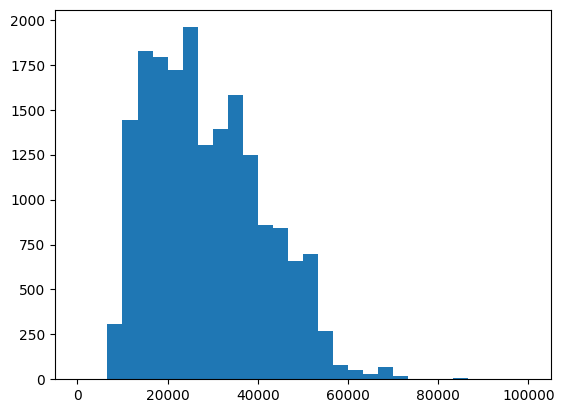

In [23]:
plt.hist(data["airports_nearest"], bins=30, range=(0, 100000))

В распределении расстояний до ближайшего аэропорта видно небольшой хвост и выброс, поэтому оптимально будет использовать медиану для заполнения пропусков в этом поле с учётом того, что это значение мало влияет на цену.

In [24]:
data["airports_nearest"] = data["airports_nearest"].fillna(value=data["airports_nearest"].median())
data["airports_nearest"].isna().sum()

0

Поле `ponds_around3000` содержит пропуски примерно в трети записей. Расссмотрим, какие значения в нём встречаются.

In [25]:
data["ponds_around3000"].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

Т.к. влияние на цену этого поля относительно невелико и парк поблизости может выступать в качестве преимущества, предположим что в записях с пропусками в этом поле рядом с недвижимостью парков нет.

Т.к. это поле связано по смыслу с полем `ponds_nearest`, 

In [26]:
data["ponds_around3000"] = data["ponds_around3000"].fillna(value=0)
data["ponds_around3000"].isna().sum()

0

Поле `ponds_nearest` содержит пропуски чуть менее чем в половине записей. Расссмотрим, как распределены существующие значения.

(array([ 49., 167., 226., 241., 260., 254., 254., 309., 285., 282., 252.,
        314., 295., 354., 417., 371., 314., 304., 318., 342., 254., 367.,
        268., 273., 214., 274., 278., 229., 243., 210., 166., 201., 134.,
        106.,  53.,  34.,  44.,  40.,  36.,  26.,  18.,  19.,   8.,   3.,
          4.,   0.,   0.,   0.,   0.,   0.]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
        1080., 1110., 1140., 1170., 1200., 1230., 1260., 1290., 1320.,
        1350., 1380., 1410., 1440., 1470., 1500.]),
 <BarContainer object of 50 artists>)

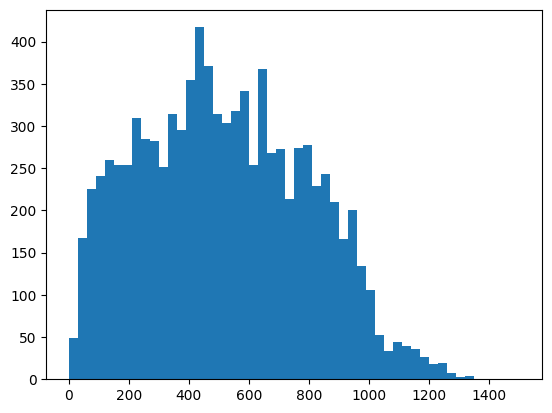

In [27]:
plt.hist(data["ponds_nearest"], bins=50, range=(0, 1500))

Т.к. влияние на цену этого поля относительно невелико предположим, что пропуски означают отсутствие водоёмов поблизости. Заменим пропуски средним значением расстояния до водоёмов рядом в зависимости от их количества. Возьмём средние значения т.к. диаграмма не содержит существенных выбросов и больших хвостов. Если же близко нет водоёмов, возьмём 75 квантиль расстояния до водоёмов в качестве расстояния предположив, что водоём есть, но находится далеко.

In [28]:
for pounds_count in data["ponds_around3000"].unique():
    pounds_subset = data.query("ponds_around3000 == @pounds_count")

    if pounds_count == 0:
        print(data["ponds_nearest"].quantile(.75))
        data["ponds_nearest"] = pd.concat([
            data.iloc[data.index.difference(pounds_subset.index)]["ponds_nearest"], 
            pounds_subset["ponds_nearest"].fillna(data["ponds_nearest"].quantile(.75))
        ])
        continue;
    
    print(pounds_subset["ponds_nearest"].mean())
    data["ponds_nearest"] = pd.concat([
        data.iloc[data.index.difference(pounds_subset.index)]["ponds_nearest"], 
        pounds_subset["ponds_nearest"].fillna(pounds_subset["ponds_nearest"].mean())
    ])
    
data["ponds_nearest"].isna().sum()

453.9318181818182
729.0
339.3031312458361
586.0893825432919


0

(array([4.9000e+01, 1.6700e+02, 2.2600e+02, 2.4100e+02, 2.6000e+02,
        2.5400e+02, 2.5400e+02, 3.0900e+02, 2.8500e+02, 2.8200e+02,
        2.5200e+02, 3.1400e+02, 2.9500e+02, 3.5400e+02, 4.1700e+02,
        3.7100e+02, 3.1400e+02, 3.0400e+02, 3.1800e+02, 3.4200e+02,
        2.5400e+02, 3.6700e+02, 2.6800e+02, 2.7300e+02, 1.4803e+04,
        2.7400e+02, 2.7800e+02, 2.2900e+02, 2.4300e+02, 2.1000e+02,
        1.6600e+02, 2.0100e+02, 1.3400e+02, 1.0600e+02, 5.3000e+01,
        3.4000e+01, 4.4000e+01, 4.0000e+01, 3.6000e+01, 2.6000e+01,
        1.8000e+01, 1.9000e+01, 8.0000e+00, 3.0000e+00, 4.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([   0.,   30.,   60.,   90.,  120.,  150.,  180.,  210.,  240.,
         270.,  300.,  330.,  360.,  390.,  420.,  450.,  480.,  510.,
         540.,  570.,  600.,  630.,  660.,  690.,  720.,  750.,  780.,
         810.,  840.,  870.,  900.,  930.,  960.,  990., 1020., 1050.,
        1080., 1110., 1140., 1170.

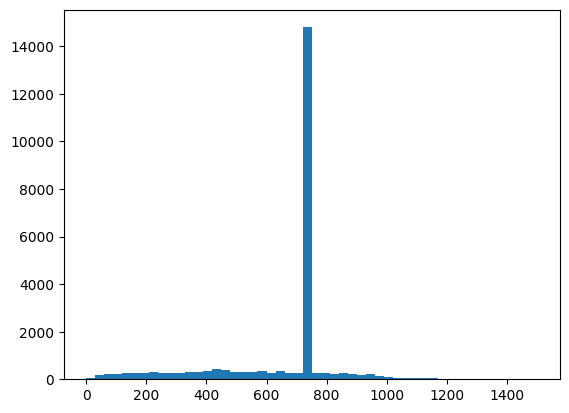

In [29]:
plt.hist(data["ponds_nearest"], bins=50, range=(0, 1500))

Поле `days_exposition`. Для начала оценим рассмотрим распределение значений.

(array([3282., 3470., 2564., 1826., 1380., 1076.,  907.,  710.,  565.,
         499.,  429.,  388.,  343.,  357.,  293.,  287.,  210.,  203.,
         156.,  163.,  151.,  120.,  105.,   94.,   81.,  105.,   57.,
          61.,   62.,   49.,   51.,   57.,   42.,   37.,   41.,   35.,
          19.,   30.,   37.,   28.,   15.,   26.,   19.,   16.,    7.,
          10.,   10.,    7.,   13.,    6.]),
 array([   0.,   28.,   56.,   84.,  112.,  140.,  168.,  196.,  224.,
         252.,  280.,  308.,  336.,  364.,  392.,  420.,  448.,  476.,
         504.,  532.,  560.,  588.,  616.,  644.,  672.,  700.,  728.,
         756.,  784.,  812.,  840.,  868.,  896.,  924.,  952.,  980.,
        1008., 1036., 1064., 1092., 1120., 1148., 1176., 1204., 1232.,
        1260., 1288., 1316., 1344., 1372., 1400.]),
 <BarContainer object of 50 artists>)

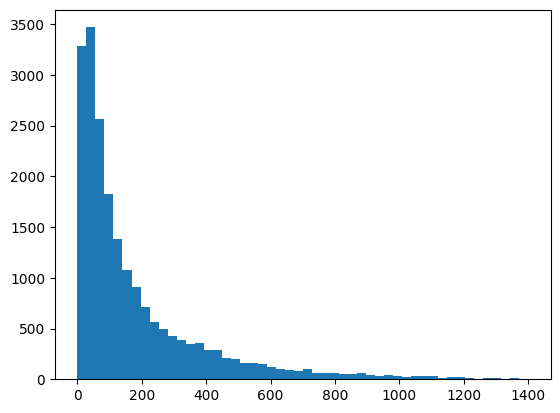

In [30]:
plt.hist(data["days_exposition"], bins=50, range=(0, 1400))

Т.к. пропусков относительно небольшое количество и распределение имеет длинный хвост, заполним пропуски медианным значением.

In [31]:
data["days_exposition"] = data["days_exposition"].fillna(value=data["days_exposition"].median())
data["days_exposition"].isna().sum()

0

Оставшиеся атрибуты данных имеют относительно высокую корреляцию с ценой, поэтому целессообразно заполнить пропуски в них сохраняя зависимости между полями данных.

(array([   8.,  252., 5972., 1852., 4973., 2282., 2540., 1505.,  724.,
         473.,  308.,  189.,  166.,  106.,   83.,   75.,   43.,   26.,
          33.,   20.,   12.,   24.,   19.,   13.,   21.,    9.,    9.,
          13.,    8.,    7.]),
 array([  0.        ,   6.66666667,  13.33333333,  20.        ,
         26.66666667,  33.33333333,  40.        ,  46.66666667,
         53.33333333,  60.        ,  66.66666667,  73.33333333,
         80.        ,  86.66666667,  93.33333333, 100.        ,
        106.66666667, 113.33333333, 120.        , 126.66666667,
        133.33333333, 140.        , 146.66666667, 153.33333333,
        160.        , 166.66666667, 173.33333333, 180.        ,
        186.66666667, 193.33333333, 200.        ]),
 <BarContainer object of 30 artists>)

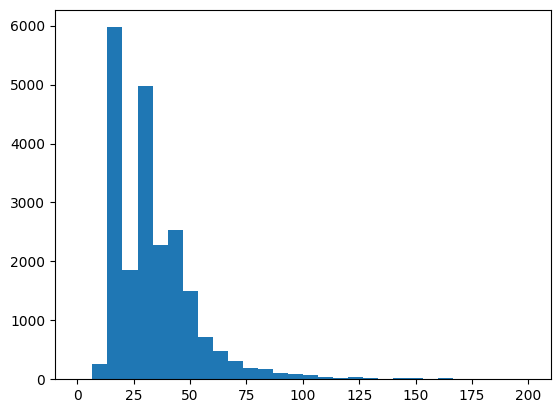

In [32]:
plt.hist(data["living_area"], bins=30, range=(0, 200))

In [33]:
data["living_area"].corr(data["last_price"])

0.5664915336952648

Для остальных атрибутов данных влияние на целевой показатель относительно велико, поэтому заменим пропуски сомоделировав исходное распределение методом Multiple Imputation.

In [34]:
selected_dtype = data.select_dtypes(include=['float64', 'int64'])
selected_dtype.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   total_images         23699 non-null  int64  
 1   last_price           23699 non-null  float64
 2   total_area           23699 non-null  float64
 3   rooms                23699 non-null  int64  
 4   ceiling_height       23699 non-null  float64
 5   floors_total         23699 non-null  float64
 6   living_area          21796 non-null  float64
 7   floor                23699 non-null  int64  
 8   kitchen_area         21421 non-null  float64
 9   balcony              23699 non-null  float64
 10  airports_nearest     23699 non-null  float64
 11  cityCenters_nearest  18180 non-null  float64
 12  parks_around3000     18181 non-null  float64
 13  parks_nearest        8079 non-null   float64
 14  ponds_around3000     23699 non-null  float64
 15  ponds_nearest        23699 non-null 

Рассчитаем пропущенные значения пользуясь доступной информацией из датасета методом Multiple Imputation с целью сохранить связи в данных и минимально исказаить распределение характеристик с большим влиянием на цену.

In [35]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
imp = IterativeImputer(estimator=regressor, missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman')
filled_data = pd.DataFrame(imp.fit_transform(selected_dtype), columns=selected_dtype.columns)

for column in filled_data.columns:
    data[column] = filled_data[column]

data.isna().sum()

[IterativeImputer] Completing matrix with shape (23699, 17)
[IterativeImputer] Ending imputation round 1/10, elapsed time 0.18
[IterativeImputer] Change: 12763.222323064594, scaled tolerance: 763000.0 
[IterativeImputer] Early stopping criterion reached.


total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

В поле `parks_nearest` больше половины записей содержат пропуски. Рассмотрим, какие значения встречаются в этом атрибуте данных.

(array([2.910e+02, 3.300e+02, 5.960e+02, 6.100e+02, 6.990e+02, 8.240e+02,
        8.810e+02, 1.521e+03, 4.494e+03, 5.545e+03, 5.208e+03, 1.714e+03,
        4.150e+02, 1.120e+02, 8.000e+01, 4.800e+01, 3.000e+01, 2.600e+01,
        3.500e+01, 3.000e+01, 9.000e+00, 1.200e+01, 3.200e+01, 6.000e+00,
        3.000e+00, 4.000e+00, 1.300e+01, 4.000e+00, 5.000e+00, 5.000e+00]),
 array([   0.        ,   66.66666667,  133.33333333,  200.        ,
         266.66666667,  333.33333333,  400.        ,  466.66666667,
         533.33333333,  600.        ,  666.66666667,  733.33333333,
         800.        ,  866.66666667,  933.33333333, 1000.        ,
        1066.66666667, 1133.33333333, 1200.        , 1266.66666667,
        1333.33333333, 1400.        , 1466.66666667, 1533.33333333,
        1600.        , 1666.66666667, 1733.33333333, 1800.        ,
        1866.66666667, 1933.33333333, 2000.        ]),
 <BarContainer object of 30 artists>)

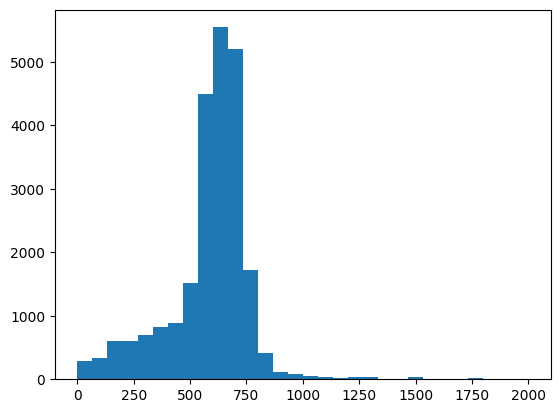

In [36]:
plt.hist(data["parks_nearest"], bins=30, range=(0, 2000))

Распределение похоже на нормальное, но есть большие хвосты и выбросы поэтому испоьзуем медиану при усреднении. Т.к. пропусков много заменим их на медианные значения расстояния до парков в соответствии с их количеством. В тех случаях, когда парков рядом нет, предположим, что они далеко и заполним пропуски 75 квантилем.

In [37]:
for parks_count in data["parks_around3000"].unique():
    parks_subset = data.query("parks_around3000 == @parks_count")

    if parks_count == 0:
        data["parks_nearest"] = pd.concat([
            data.iloc[data.index.difference(parks_subset.index)]["parks_nearest"], 
            parks_subset["parks_nearest"].fillna(data["parks_nearest"].quantile(.75))
        ])
        continue;
    
    data["parks_nearest"] = pd.concat([
        data.iloc[data.index.difference(parks_subset.index)]["parks_nearest"], 
        parks_subset["parks_nearest"].fillna(parks_subset["parks_nearest"].median())
    ])

data["parks_nearest"].isna().sum()

0

(array([2.910e+02, 3.300e+02, 5.960e+02, 6.100e+02, 6.990e+02, 8.240e+02,
        8.810e+02, 1.521e+03, 4.494e+03, 5.545e+03, 5.208e+03, 1.714e+03,
        4.150e+02, 1.120e+02, 8.000e+01, 4.800e+01, 3.000e+01, 2.600e+01,
        3.500e+01, 3.000e+01, 9.000e+00, 1.200e+01, 3.200e+01, 6.000e+00,
        3.000e+00, 4.000e+00, 1.300e+01, 4.000e+00, 5.000e+00, 5.000e+00]),
 array([   0.        ,   66.66666667,  133.33333333,  200.        ,
         266.66666667,  333.33333333,  400.        ,  466.66666667,
         533.33333333,  600.        ,  666.66666667,  733.33333333,
         800.        ,  866.66666667,  933.33333333, 1000.        ,
        1066.66666667, 1133.33333333, 1200.        , 1266.66666667,
        1333.33333333, 1400.        , 1466.66666667, 1533.33333333,
        1600.        , 1666.66666667, 1733.33333333, 1800.        ,
        1866.66666667, 1933.33333333, 2000.        ]),
 <BarContainer object of 30 artists>)

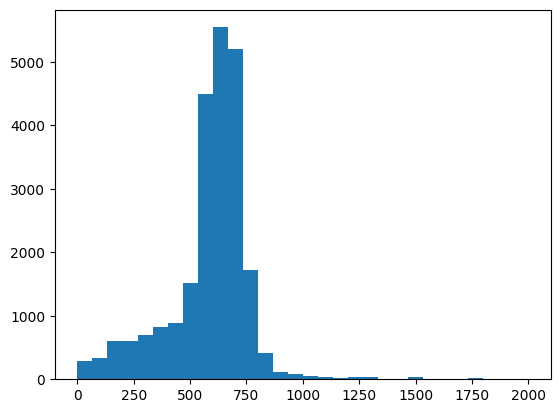

In [38]:
plt.hist(data["parks_nearest"], bins=30, range=(0, 2000))

Убедимся, что всё пропуски заполнены.

In [39]:
data.isna().sum()

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

Приведём данные в соответствующие хранимым значениям типы Pandas.

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  float64
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  float64
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23699 non-null  float64
 7   living_area           23699 non-null  float64
 8   floor                 23699 non-null  float64
 9   is_apartment          23699 non-null  bool   
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          23699 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23699 non-null  object 
 15  airports_nearest   

In [41]:
data = data.astype({
        'total_images' : 'int64',
        'last_price' : 'int64',
        'first_day_exposition': 'datetime64',
        'rooms': 'int64',
        'floors_total' : 'int64',
        'floor' : 'int64',
        'is_apartment' : 'bool',
        'balcony' : 'int64',
        'airports_nearest' : 'int64',
        'cityCenters_nearest' : 'int64',
        'parks_around3000' : 'int64',
        'parks_nearest' : 'int64',
        'ponds_around3000' : 'int64',
        'ponds_nearest' : 'int64',
        'days_exposition' : 'int64'
    })
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23699 non-null  int64         
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

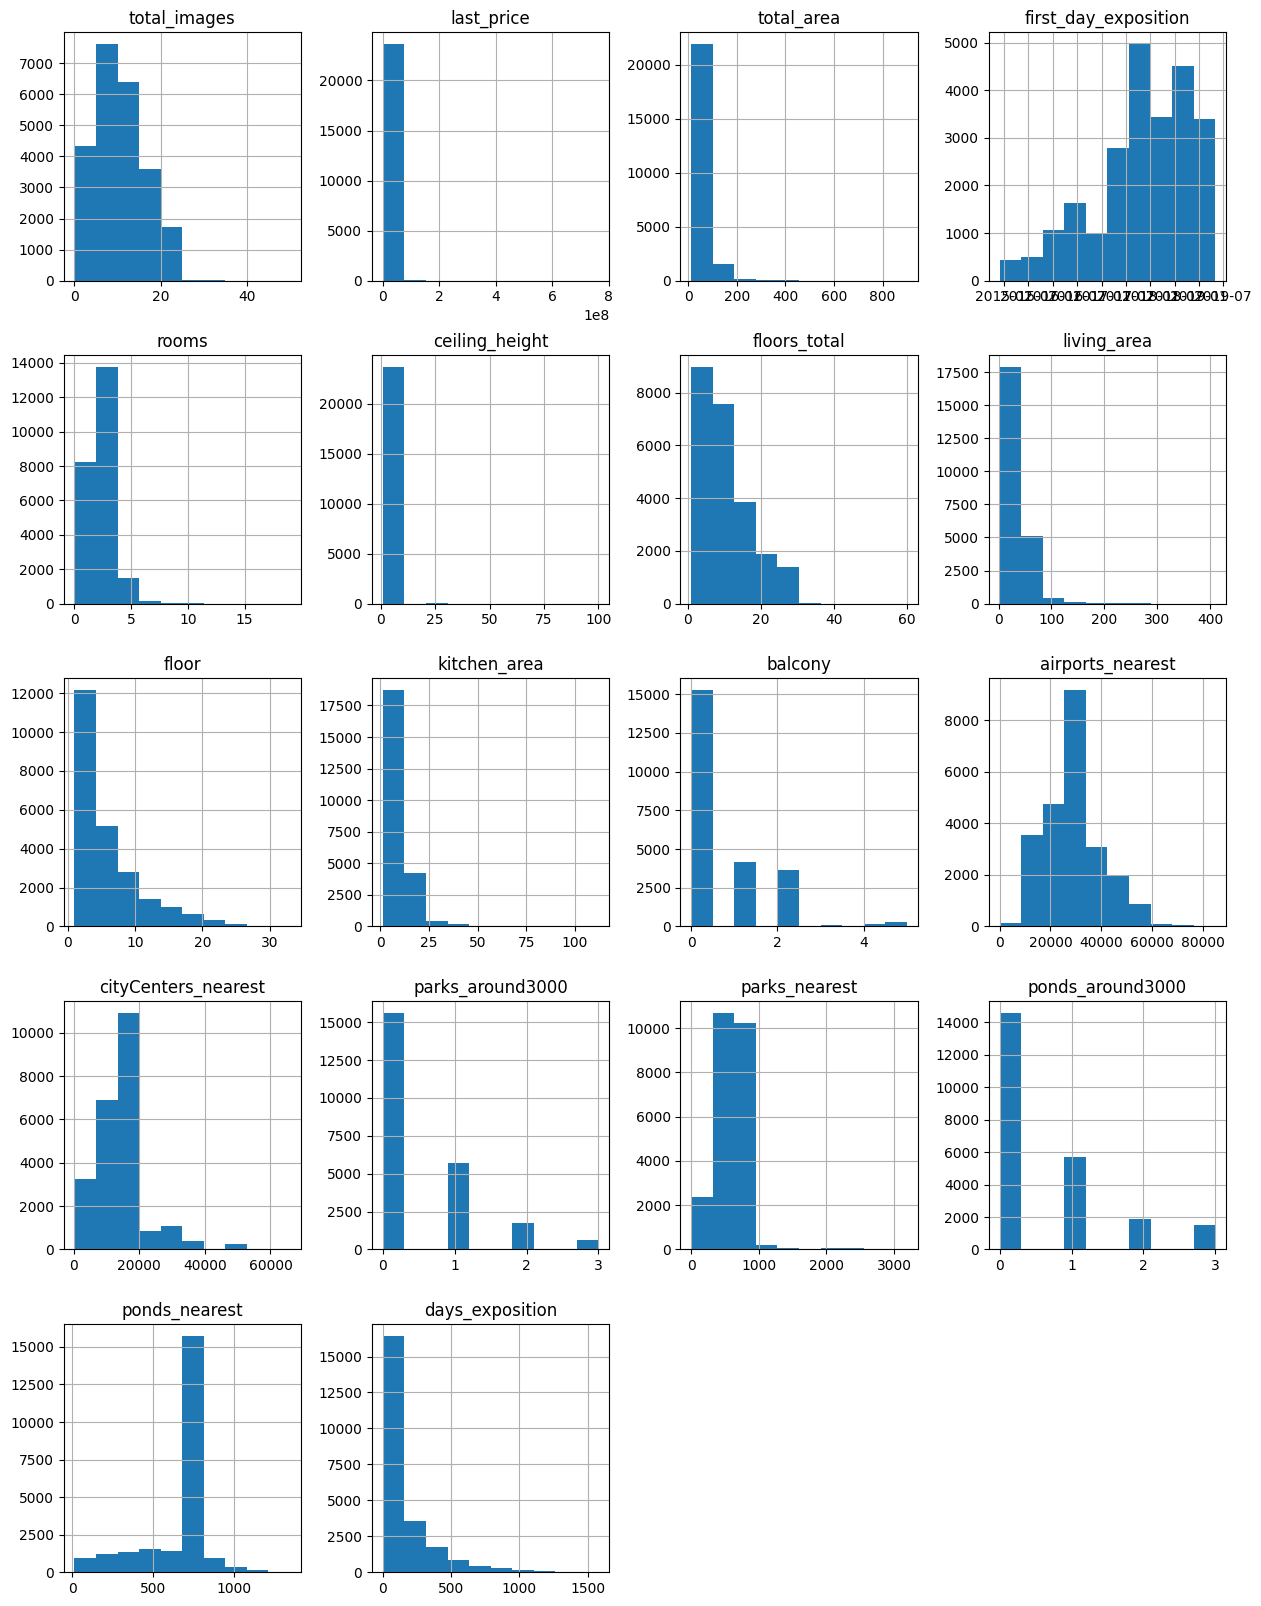

In [42]:
data.hist(figsize=(15, 20))

Изучим количество уникальных названий населённых пунктов.

In [43]:
unique_names = pd.Series(data["locality_name"].unique())
unique_names

0                Санкт-Петербург
1                 посёлок Шушары
2      городской посёлок Янино-1
3              посёлок Парголово
4                 посёлок Мурино
                 ...            
360               деревня Нижняя
361    коттеджный посёлок Лесное
362            деревня Тихковицы
363       деревня Борисова Грива
364         посёлок Дзержинского
Length: 365, dtype: object

Проверим наличие явных дубликатов.

In [44]:
unique_names.duplicated().sum()

0

Воспользуемся расстоянием Левенштайна между строками чтобы найти неявные дубликаты т.к. уникальных значений достаточно много чтобы обрабатывать их вручную и достаочно мало, чтобы алгоритм сработал за относительно непродолжительное время. 

In [45]:
def print_duplicates(strings, dist):
    duplicates_count = 0

    for i in range(0, len(strings)):
        for j in range(i, len(strings)):
            if i == j: continue

            if distance(strings[i], strings[j]) <= dist:
                print(strings[i], '\t', strings[j])
                duplicates_count += 1
            
    print(f"Duplicates count: {duplicates_count}")

print_duplicates(unique_names, 1)

городской посёлок Янино-1 	 городской поселок Янино-1
посёлок Мурино 	 поселок Мурино
поселок городского типа Красный Бор 	 посёлок городского типа Красный Бор
посёлок городского типа Лебяжье 	 поселок городского типа Лебяжье
поселок городского типа Кузьмоловский 	 посёлок городского типа Кузьмоловский
посёлок Аннино 	 поселок Аннино
посёлок Новый Свет 	 поселок Новый Свет
деревня Кальтино 	 деревня Калитино
посёлок Бугры 	 поселок Бугры
поселок городского типа Рощино 	 посёлок городского типа Рощино
посёлок Победа 	 поселок Победа
поселок Терволово 	 посёлок Терволово
посёлок Петровское 	 поселок Петровское
посёлок городского типа Токсово 	 поселок городского типа Токсово
посёлок городского типа Вырица 	 поселок городского типа Вырица
посёлок Тельмана 	 поселок Тельмана
поселок городского типа имени Свердлова 	 посёлок городского типа имени Свердлова
посёлок Поляны 	 поселок Поляны
посёлок Мичуринское 	 поселок Мичуринское
поселок Ильичёво 	 посёлок Ильичёво
посёлок Гаврилово 	 посело

Заменим везде букву `ё` на `е`.

In [46]:
data["locality_name"] = data["locality_name"].str.replace('ё','е')
unique_names = pd.Series(data["locality_name"].unique())
print_duplicates(unique_names, 1)

деревня Кальтино 	 деревня Калитино
деревня Курковицы 	 деревня Куровицы
Duplicates count: 2


Проанализировав на Яндекс.Картах эти 2 сочетания приходим к выводу, что это разные населённые пункты. Далее найдём сочетания с расстоянием Левенштайна равным 2.

In [47]:
print_duplicates(unique_names, 2)

поселок Парголово 	 поселок Гарболово
поселок Мурино 	 поселок Сумино
поселок городского типа Сиверский 	 поселок городского типа Советский
деревня Кальтино 	 деревня Калитино
поселок Щеглово 	 поселок Углово
поселок Саперный 	 поселок Саперное
поселок Семрино 	 поселок Сумино
деревня Тарасово 	 деревня Торосово
деревня Курковицы 	 деревня Куровицы
деревня Рапполово 	 деревня Лупполово
Duplicates count: 10


Все сочетания выглядят как уникальные населённые пункты. На всякий случай проверим сочетания с расстоянием Левенштайна в 3.

In [48]:
print_duplicates(unique_names, 3)

поселок Шушары 	 поселок Бугры
поселок Парголово 	 поселок Терволово
поселок Парголово 	 поселок Гарболово
поселок Мурино 	 поселок Аннино
поселок Мурино 	 поселок Репино
поселок Мурино 	 поселок Семрино
поселок Мурино 	 поселок Сумино
деревня Кудрово 	 деревня Реброво
Выборг 	 Высоцк
поселок городского типа Сиверский 	 поселок городского типа Советский
деревня Пикколово 	 деревня Лесколово
деревня Пикколово 	 деревня Мистолово
Волхов 	 Волосово
Приозерск 	 Приморск
деревня Куттузи 	 деревня Колтуши
поселок Аннино 	 поселок Репино
поселок Аннино 	 поселок Сумино
поселок Плодовое 	 поселок Плоское
деревня Лесколово 	 деревня Лаголово
деревня Лесколово 	 деревня Мистолово
деревня Лесколово 	 деревня Лупполово
село Путилово 	 село Павлово
деревня Оржицы 	 деревня Парицы
деревня Кальтино 	 деревня Калитино
деревня Нурма 	 деревня Пижма
поселок Терволово 	 поселок Гарболово
деревня Лаголово 	 деревня Гарболово
деревня Лаголово 	 деревня Лампово
деревня Лаголово 	 деревня Щеглово
деревня Лаг

Делаем вывод, что дубликатов в названиях населённых пунктов больше нет.

### Добавьте в таблицу новые столбцы

Добавим поле с ценой за квадратный метр.

In [49]:
data["square_price"] = (data["last_price"] / data["total_area"]).round(2)
data["square_price"]

0        120370.37
1         82920.79
2         92785.71
3        408176.10
4        100000.00
           ...    
23694     72490.85
23695     52542.37
23696     44091.71
23697    149511.40
23698     41795.67
Name: square_price, Length: 23699, dtype: float64

Добавим номер дня недели.

In [50]:
data["day_index"] = data["first_day_exposition"].dt.weekday
data["day_index"]

0        3
1        1
2        3
3        4
4        1
        ..
23694    1
23695    0
23696    6
23697    1
23698    4
Name: day_index, Length: 23699, dtype: int64

Добавим номер месяца в году.

In [51]:
data["month_index"] = data["first_day_exposition"].dt.month
data["month_index"]

0         3
1        12
2         8
3         7
4         6
         ..
23694     3
23695     1
23696     2
23697     3
23698     7
Name: month_index, Length: 23699, dtype: int64

Добавим номер года.

In [52]:
data["year_index"] = data["first_day_exposition"].dt.year
data["year_index"]

0        2019
1        2018
2        2015
3        2015
4        2018
         ... 
23694    2017
23695    2018
23696    2018
23697    2017
23698    2017
Name: year_index, Length: 23699, dtype: int64

Добавим тип этажа квартиры: «первый», «последний», «другой».

In [53]:
def floor_type(df):
    if df["floor"] == 1:
        return "первый"
    elif df["floor"] == df["floors_total"]:
        return "последний"
    else:
        return "другой"

data["floor_type"] = data.apply(floor_type, axis=1)
data["floor_type"].nunique()

3

Добавим расстояние до центра города в километрах.

In [54]:
data["city_center_km"] = (data["cityCenters_nearest"] / 1000).round(2)
data["city_center_km"]

0        16.03
1        18.60
2        13.93
3         6.80
4         8.10
         ...  
23694     4.23
23695    14.10
23696    14.74
23697    10.36
23698    16.03
Name: city_center_km, Length: 23699, dtype: float64

### Проведите исследовательский анализ данных

Перед отсечением выбросов сохраним количество записей в наборе данных чтобы получить в конце информацию о потерях в количестве записей после чистки.

In [55]:
rows_before_purge = len(data)

Исследуем гистограмму распреденения площади недвижимости `total_area`.

(array([4.300e+01, 6.300e+02, 4.568e+03, 5.015e+03, 3.291e+03, 3.236e+03,
        2.075e+03, 1.470e+03, 8.540e+02, 7.130e+02, 3.800e+02, 3.080e+02,
        2.160e+02, 1.600e+02, 1.050e+02, 1.150e+02, 8.700e+01, 7.100e+01,
        5.500e+01, 4.200e+01, 3.200e+01, 2.600e+01, 2.400e+01, 1.900e+01,
        1.800e+01, 1.900e+01, 2.000e+01, 1.200e+01, 4.000e+00, 6.000e+00,
        1.100e+01, 1.000e+01, 5.000e+00, 7.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 7.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

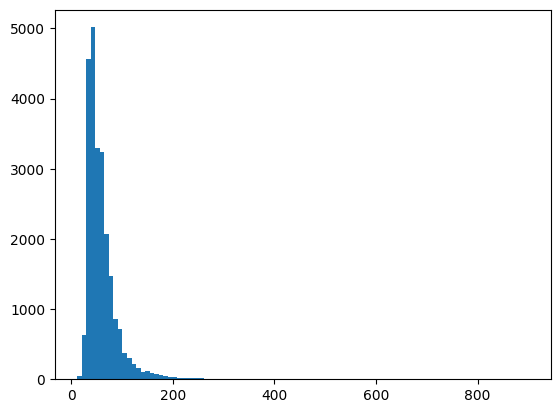

In [56]:
plt.hist(data["total_area"], bins=100)

Частотность недвижимости с большими значениями площади низкая. Т.к. предыдущий график не показывает явно выбросы, рассмотрим его же в логарифмическом масштабе.

(array([4.300e+01, 6.300e+02, 4.568e+03, 5.015e+03, 3.291e+03, 3.236e+03,
        2.075e+03, 1.470e+03, 8.540e+02, 7.130e+02, 3.800e+02, 3.080e+02,
        2.160e+02, 1.600e+02, 1.050e+02, 1.150e+02, 8.700e+01, 7.100e+01,
        5.500e+01, 4.200e+01, 3.200e+01, 2.600e+01, 2.400e+01, 1.900e+01,
        1.800e+01, 1.900e+01, 2.000e+01, 1.200e+01, 4.000e+00, 6.000e+00,
        1.100e+01, 1.000e+01, 5.000e+00, 7.000e+00, 4.000e+00, 2.000e+00,
        2.000e+00, 3.000e+00, 1.000e+00, 6.000e+00, 4.000e+00, 2.000e+00,
        0.000e+00, 7.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 3.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

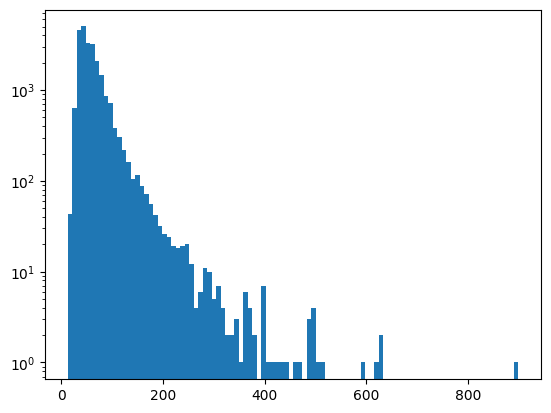

In [57]:
plt.hist(data["total_area"], bins=100, log=True)

Исходя из непрерывности значений площади делаем вывод, что большие значения площади больше 500 метров можно считать выбросами. Посчитаем их количество и выбросим из набора данных если их более чем на два порядка меньше, чем количества записей.

In [58]:
print(f"Выбросов по общей площади в процентах: {100 * len(data[data['total_area'] > 400]['total_area']) / len(data):.2f}")

Выбросов по общей площади в процентах: 0.10


In [59]:
data = data[data['total_area'] <= 400]

Повторим предыдущий процесс для жилой площади `living_area`.

(array([6.000e+00, 1.900e+01, 3.700e+01, 1.810e+02, 1.004e+03, 3.080e+03,
        3.055e+03, 6.300e+02, 4.960e+02, 1.727e+03, 2.185e+03, 1.785e+03,
        1.143e+03, 8.620e+02, 1.122e+03, 1.156e+03, 9.160e+02, 8.180e+02,
        5.040e+02, 4.880e+02, 3.810e+02, 2.210e+02, 2.310e+02, 1.900e+02,
        1.550e+02, 1.610e+02, 9.800e+01, 1.040e+02, 9.600e+01, 9.000e+01,
        6.600e+01, 5.200e+01, 5.600e+01, 4.900e+01, 3.500e+01, 5.100e+01,
        2.800e+01, 3.900e+01, 3.500e+01, 1.900e+01, 1.900e+01, 2.500e+01,
        7.000e+00, 1.700e+01, 1.300e+01, 8.000e+00, 1.400e+01, 1.400e+01,
        1.000e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.300e+01, 7.000e+00,
        1.200e+01, 8.000e+00, 1.000e+01, 4.000e+00, 4.000e+00, 3.000e+00,
        2.000e+01, 4.000e+00, 8.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 8.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

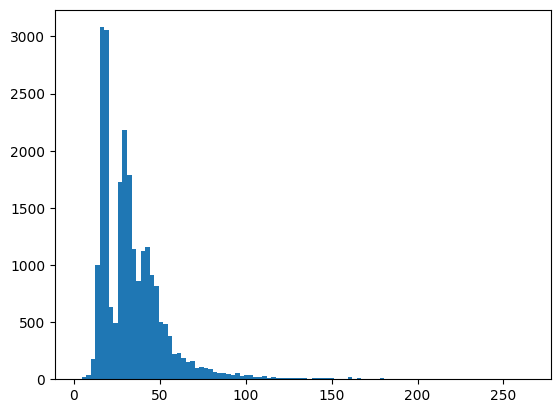

In [60]:
plt.hist(data["living_area"], bins=100)

(array([6.000e+00, 1.900e+01, 3.700e+01, 1.810e+02, 1.004e+03, 3.080e+03,
        3.055e+03, 6.300e+02, 4.960e+02, 1.727e+03, 2.185e+03, 1.785e+03,
        1.143e+03, 8.620e+02, 1.122e+03, 1.156e+03, 9.160e+02, 8.180e+02,
        5.040e+02, 4.880e+02, 3.810e+02, 2.210e+02, 2.310e+02, 1.900e+02,
        1.550e+02, 1.610e+02, 9.800e+01, 1.040e+02, 9.600e+01, 9.000e+01,
        6.600e+01, 5.200e+01, 5.600e+01, 4.900e+01, 3.500e+01, 5.100e+01,
        2.800e+01, 3.900e+01, 3.500e+01, 1.900e+01, 1.900e+01, 2.500e+01,
        7.000e+00, 1.700e+01, 1.300e+01, 8.000e+00, 1.400e+01, 1.400e+01,
        1.000e+01, 9.000e+00, 7.000e+00, 5.000e+00, 1.300e+01, 7.000e+00,
        1.200e+01, 8.000e+00, 1.000e+01, 4.000e+00, 4.000e+00, 3.000e+00,
        2.000e+01, 4.000e+00, 8.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 8.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+0

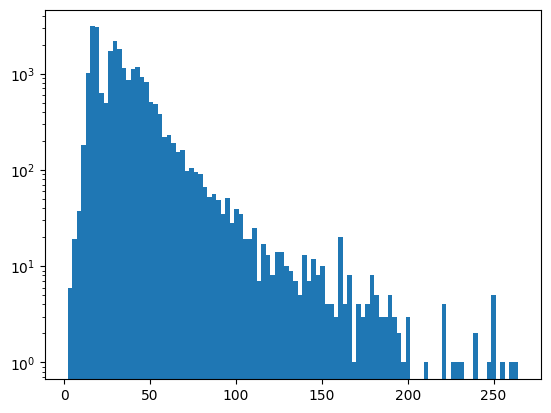

In [61]:
plt.hist(data["living_area"], bins=100, log=True)

Учитывая распределения в обычном и логарифмическом масштабе, предположим, что выбросами можно считать значения большие 175 метров. Проверим это посчитав, сколько таких значений в выборке.

In [62]:
print(f"Выбросов по жилой площади в процентах: {100 * len(data[data['living_area'] > 175]['living_area']) / len(data):.2f}")

Выбросов по жилой площади в процентах: 0.24


In [63]:
data = data[data['living_area'] <= 175]

In [64]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'square_price', 'day_index',
       'month_index', 'year_index', 'floor_type', 'city_center_km'],
      dtype='object')

Повторим предыдущий процесс для кухонной площади `kitchen_area`.

(array([1.000e+01, 1.200e+01, 5.100e+01, 1.310e+03, 2.885e+03, 2.546e+03,
        3.310e+03, 2.685e+03, 3.100e+03, 1.830e+03, 1.430e+03, 8.720e+02,
        1.112e+03, 4.720e+02, 3.380e+02, 2.590e+02, 1.790e+02, 2.220e+02,
        1.020e+02, 1.240e+02, 9.900e+01, 7.500e+01, 9.000e+01, 4.200e+01,
        3.000e+01, 4.700e+01, 2.400e+01, 7.100e+01, 2.200e+01, 2.900e+01,
        1.200e+01, 3.500e+01, 2.000e+01, 1.300e+01, 1.600e+01, 8.000e+00,
        3.000e+01, 1.100e+01, 9.000e+00, 1.000e+01, 4.000e+00, 1.600e+01,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 9.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

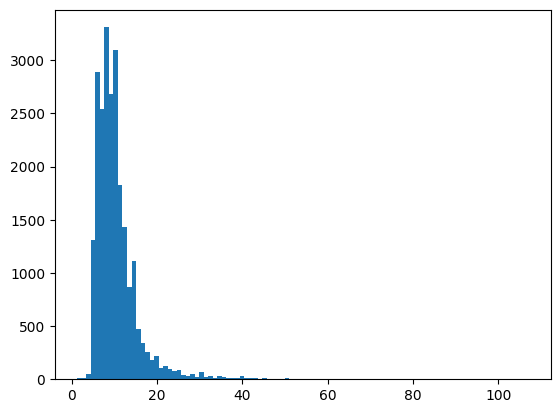

In [65]:
plt.hist(data["kitchen_area"], bins=100)

(array([1.000e+01, 1.200e+01, 5.100e+01, 1.310e+03, 2.885e+03, 2.546e+03,
        3.310e+03, 2.685e+03, 3.100e+03, 1.830e+03, 1.430e+03, 8.720e+02,
        1.112e+03, 4.720e+02, 3.380e+02, 2.590e+02, 1.790e+02, 2.220e+02,
        1.020e+02, 1.240e+02, 9.900e+01, 7.500e+01, 9.000e+01, 4.200e+01,
        3.000e+01, 4.700e+01, 2.400e+01, 7.100e+01, 2.200e+01, 2.900e+01,
        1.200e+01, 3.500e+01, 2.000e+01, 1.300e+01, 1.600e+01, 8.000e+00,
        3.000e+01, 1.100e+01, 9.000e+00, 1.000e+01, 4.000e+00, 1.600e+01,
        4.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 9.000e+00, 3.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

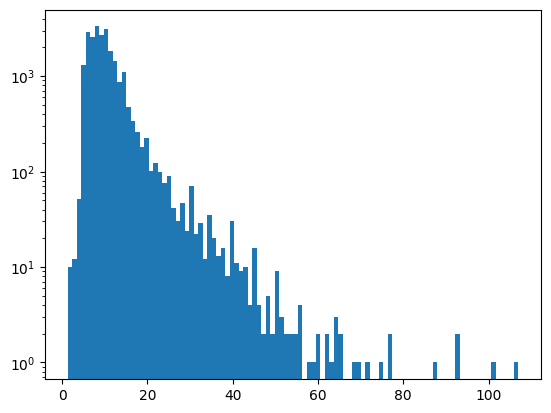

In [66]:
plt.hist(data["kitchen_area"], bins=100, log=True)

Учитывая распределения в обычном и логарифмическом масштабе, предположим, что выбросами можно считать значения большие 50 метров. Проверим это посчитав, сколько таких значений в выборке.

In [67]:
print(f"Выбросов по площади кухни в процентах: {100 * len(data[data['kitchen_area'] > 50]['kitchen_area']) / len(data):.2f}")

Выбросов по площади кухни в процентах: 0.16


In [68]:
data = data[data['kitchen_area'] <= 50]

In [69]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'studio', 'open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'square_price', 'day_index',
       'month_index', 'year_index', 'floor_type', 'city_center_km'],
      dtype='object')

Рассмотрим рассперделдение цен на недвижимость `last_price`.

(array([5.4730e+03, 1.2037e+04, 3.3490e+03, 1.2300e+03, 5.8900e+02,
        2.7100e+02, 1.7500e+02, 1.2800e+02, 7.4000e+01, 5.2000e+01,
        3.8000e+01, 2.9000e+01, 2.4000e+01, 1.7000e+01, 1.0000e+01,
        1.5000e+01, 1.1000e+01, 5.0000e+00, 6.0000e+00, 7.0000e+00,
        7.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

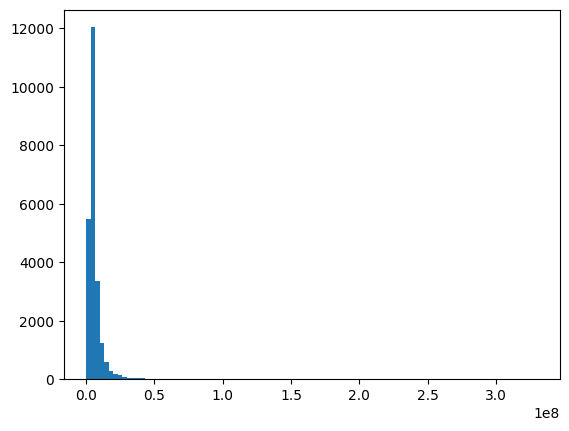

In [70]:
plt.hist(data["last_price"], bins=100)

(array([5.4730e+03, 1.2037e+04, 3.3490e+03, 1.2300e+03, 5.8900e+02,
        2.7100e+02, 1.7500e+02, 1.2800e+02, 7.4000e+01, 5.2000e+01,
        3.8000e+01, 2.9000e+01, 2.4000e+01, 1.7000e+01, 1.0000e+01,
        1.5000e+01, 1.1000e+01, 5.0000e+00, 6.0000e+00, 7.0000e+00,
        7.0000e+00, 2.0000e+00, 4.0000e+00, 5.0000e+00, 4.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

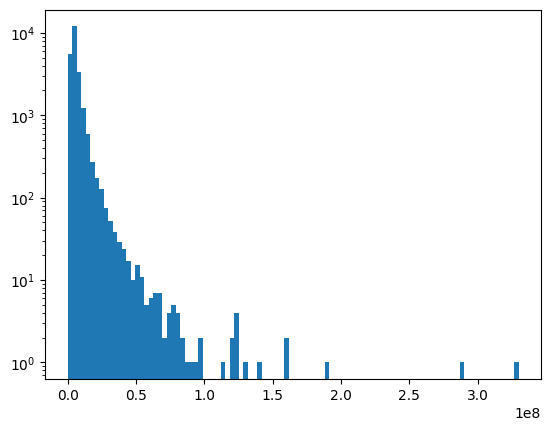

In [71]:
plt.hist(data["last_price"], bins=100, log=True)

Предположим по обоим графикам распределения, что цены более 30 миллионов встречаются редко. Проверим это предположение.

In [72]:
print(f"Выбросов по цене недвижимости в процентах: {100 * len(data[data['last_price'] > 30_000_000]['last_price']) / len(data):.2f}")

Выбросов по цене недвижимости в процентах: 1.00


Т.к. цена является целевым показателем, не спешим принимать решения и расмотрим boxplot для этого атрибута данных.

{'whiskers': [<matplotlib.lines.Line2D at 0x220f8094a30>,
 'caps': [<matplotlib.lines.Line2D at 0x220f809e130>,
 'boxes': [<matplotlib.lines.Line2D at 0x220f80946a0>],
 'medians': [<matplotlib.lines.Line2D at 0x220f809e7f0>],
 'fliers': [<matplotlib.lines.Line2D at 0x220f809eb50>],
 'means': []}

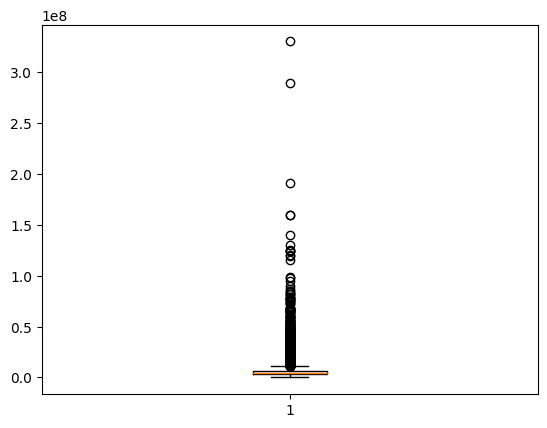

In [73]:
plt.boxplot(data['last_price'])

Явно видно, что значения больше 150_000_000 можно считать выбросами. Обрежим выбросы более 150_000_000 по цене и посмотрим на boxplot ещё раз.

{'whiskers': [<matplotlib.lines.Line2D at 0x220f94fb640>,
 'caps': [<matplotlib.lines.Line2D at 0x220f94fbd00>,
 'boxes': [<matplotlib.lines.Line2D at 0x220f94fb2e0>],
 'medians': [<matplotlib.lines.Line2D at 0x220f9507400>],
 'fliers': [<matplotlib.lines.Line2D at 0x220f9507760>],
 'means': []}

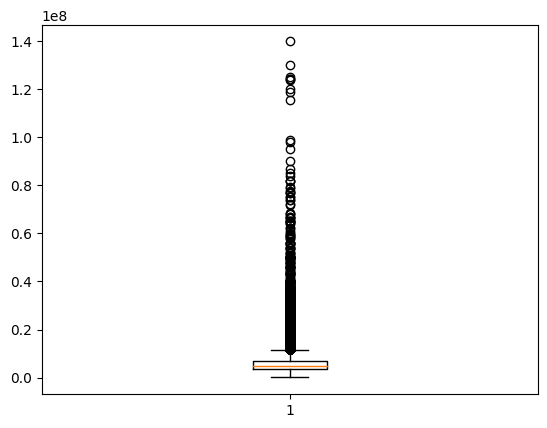

In [74]:
plt.boxplot(data[data['last_price'] <= 150_000_000]['last_price'])

На этом графике видно явно, что реже встречаются цены более 100_000_000. Посмотрим, сколько таких объявлений.

In [75]:
print(f"Выбросов по цене недвижимости в процентах: {100 * len(data[data['last_price'] > 100_000_000]['last_price']) / len(data):.2f}")

Выбросов по цене недвижимости в процентах: 0.06


Остановимся на том, что выбросами будем считать цены большие чем 100_000_000.

In [76]:
data = data[data['last_price'] <= 100_000_000]

Рассмотрим рассперделдение объявлений по колдичеству комнат `rooms`.

(array([1.960e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 8.045e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 7.934e+03, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 5.794e+03, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.158e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.010e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        8.900e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.600e+01, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 7.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+0

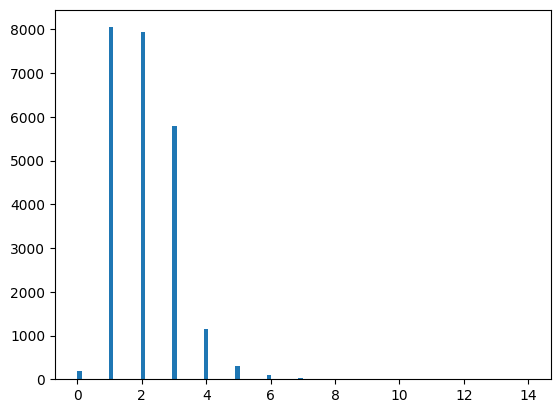

In [77]:
plt.hist(data["rooms"], bins=100)

На графике явно видно, что относительно редко встречаются квартиры более чем с шестью комнатами. Проверим, сколько таких квартир в объявлениях.

In [78]:
print(f"Выбросы по количеству комнат в процентах: {100 * len(data[data['rooms'] > 6]['rooms']) / len(data):.2f}")

Выбросы по количеству комнат в процентах: 0.22


Так и есть, будем считать все объявления с количеством комнат более 6 выбросами.

In [79]:
data = data[data['rooms'] <= 6]

Рассмотрим рассперделдение высоты потолков `ceiling_height`.

(array([3.0000e+00, 2.0979e+04, 2.4330e+03, 6.8000e+01, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 7.0000e+00,
        1.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

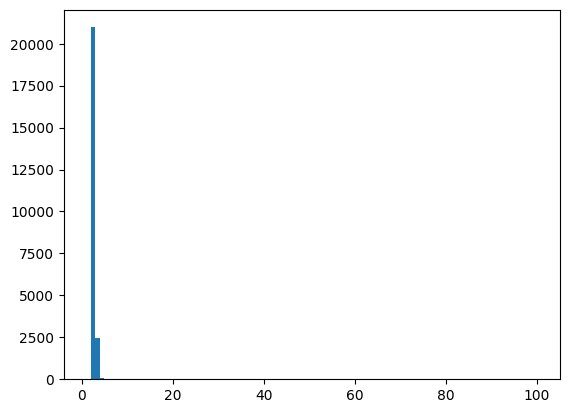

In [80]:
plt.hist(data["ceiling_height"], bins=100)

(array([3.0000e+00, 2.0979e+04, 2.4330e+03, 6.8000e+01, 5.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00, 7.0000e+00,
        1.0000e+00, 9.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

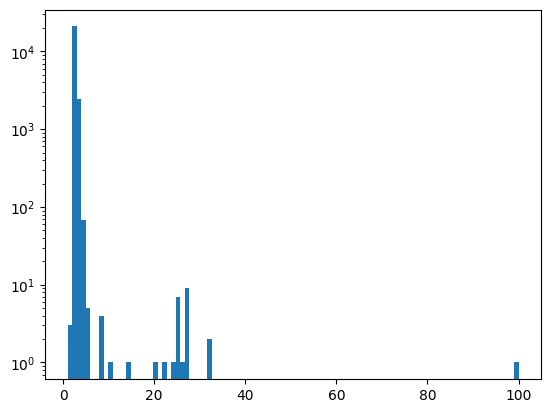

In [81]:
plt.hist(data["ceiling_height"], bins=100, log=True)

Значений не очень много, поэтому изучим их частотность аналитически.

In [82]:
data["ceiling_height"].value_counts()

2.65     9814
2.50     3514
2.60     1646
2.70     1571
3.00     1096
         ... 
14.00       1
4.45        1
3.59        1
5.20        1
22.60       1
Name: ceiling_height, Length: 176, dtype: int64

Всё же значений достаточно много, что не было отражено на первом графике. Рассмотрим boxplot чтобы лучше понять распеределение.

{'whiskers': [<matplotlib.lines.Line2D at 0x220f7e52df0>,
 'caps': [<matplotlib.lines.Line2D at 0x220f7e5d4f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x220f7e52a60>],
 'medians': [<matplotlib.lines.Line2D at 0x220f7e5dbb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x220f7e5df10>],
 'means': []}

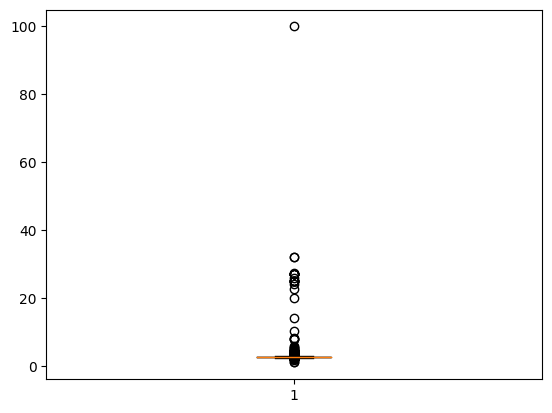

In [83]:
plt.boxplot(data["ceiling_height"])

Предположим, что значения от 10 до 40 метров записаны как целочисленные, но их размерность в 10 раз ниже и фактически это не целочисленные значения. Преобразуем эти значения и удалим выброс в районе 100 метров.

In [84]:
data = data[data['ceiling_height'] <= 40]
data = data.reset_index(drop=True)

In [85]:
height_subset = data[data["ceiling_height"] > 10]
data["ceiling_height"] = pd.concat([
            data.iloc[data.index.difference(height_subset.index)]["ceiling_height"], 
            height_subset["ceiling_height"] / 10
        ])
data = data[data["ceiling_height"].notna()]
data = data.reset_index(drop=True)

23516

(array([2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.200e+01, 0.000e+00, 0.000e+00, 1.000e+00, 6.000e+00,
        1.000e+00, 3.900e+01, 3.715e+03, 3.028e+03, 9.980e+03, 2.621e+03,
        1.200e+03, 1.630e+02, 2.330e+02, 1.123e+03, 2.930e+02, 1.100e+02,
        3.260e+02, 1.550e+02, 1.170e+02, 2.100e+01, 1.500e+02, 4.500e+01,
        4.000e+01, 9.000e+00, 2.400e+01, 1.300e+01, 1.000e+01, 3.600e+01,
        3.000e+00, 1.300e+01, 1.000e+00, 1.000e+00, 3.000e+00, 8.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

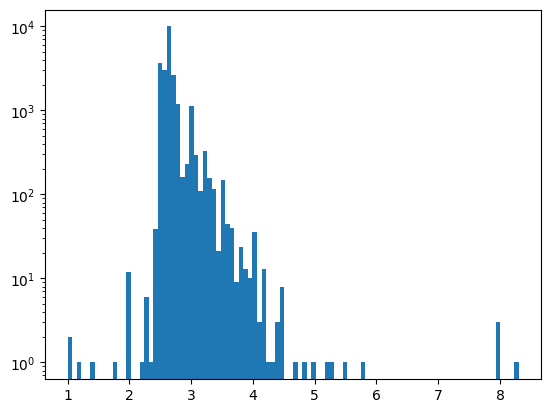

In [86]:
plt.hist(data["ceiling_height"], bins=100, log=True)

Теперь значения высоты потолковы выглядят более правдоподобно если допустить наличие коммерческой недвижимости в выборке.

Рассмотрим рассперделдение типов этажей `floor_type`.

(array([17329.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,  2905.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,  3282.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 

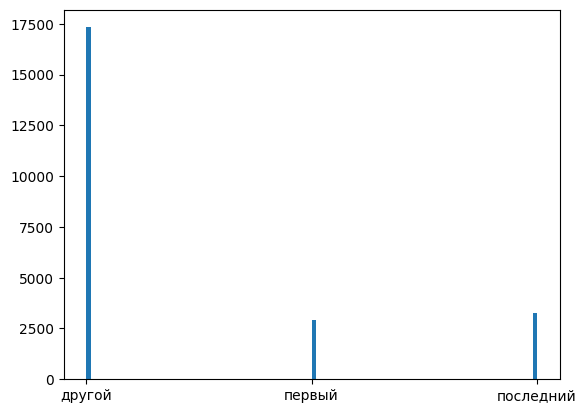

In [87]:
plt.hist(data["floor_type"], bins=100)

Большинство квартир ожидаемо находятся между первым и последним этажами.

Рассмотрим рассперделдение высоты зданий, в которых продаётся недвижимость `floors_total`.

(array([2.500e+01, 3.770e+02, 0.000e+00, 6.580e+02, 0.000e+00, 1.173e+03,
        5.742e+03, 0.000e+00, 8.750e+02, 0.000e+00, 5.710e+02, 3.830e+02,
        0.000e+00, 3.751e+03, 0.000e+00, 1.256e+03, 2.030e+02, 0.000e+00,
        1.360e+03, 0.000e+00, 2.280e+02, 0.000e+00, 5.520e+02, 3.650e+02,
        0.000e+00, 1.373e+03, 0.000e+00, 8.320e+02, 5.040e+02, 0.000e+00,
        3.390e+02, 0.000e+00, 2.680e+02, 1.580e+02, 0.000e+00, 2.860e+02,
        0.000e+00, 3.520e+02, 4.690e+02, 0.000e+00, 1.074e+03, 0.000e+00,
        1.240e+02, 0.000e+00, 1.640e+02, 2.100e+01, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 2.400e+01, 0.000e+00, 3.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

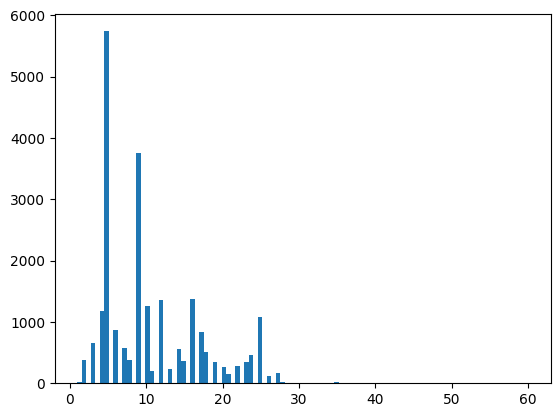

In [88]:
plt.hist(data["floors_total"], bins=100)

Заметим, что больше всего квартир в домах ниже 10 этажей, но много и домов выше с объявлениями.

Рассмотрим рассперделдение расстояний до центра города `cityCenters_nearest`.

(array([6.400e+01, 1.340e+02, 1.550e+02, 1.930e+02, 2.730e+02, 3.810e+02,
        5.650e+02, 5.950e+02, 4.460e+02, 3.030e+02, 2.530e+02, 2.690e+02,
        4.860e+02, 3.900e+02, 4.840e+02, 5.450e+02, 8.630e+02, 1.058e+03,
        1.201e+03, 1.315e+03, 1.527e+03, 1.909e+03, 2.442e+03, 1.999e+03,
        1.311e+03, 7.440e+02, 3.630e+02, 2.140e+02, 2.640e+02, 1.410e+02,
        5.500e+01, 9.900e+01, 1.850e+02, 1.050e+02, 8.200e+01, 7.300e+01,
        7.100e+01, 3.900e+01, 6.900e+01, 8.400e+01, 7.400e+01, 6.200e+01,
        7.400e+01, 7.800e+01, 1.090e+02, 1.420e+02, 1.810e+02, 1.430e+02,
        1.080e+02, 1.150e+02, 6.400e+01, 1.360e+02, 5.900e+01, 7.200e+01,
        2.400e+01, 9.000e+00, 5.000e+00, 0.000e+00, 1.000e+00, 2.000e+00,
        1.500e+01, 8.000e+00, 4.000e+00, 5.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 2.000e+01,
        1.000e+00, 1.700e+01, 1.900e+01, 3.300e+01, 2.900e+01, 4.200e+01,
        4.400e+01, 2.100e+01, 1.900e+0

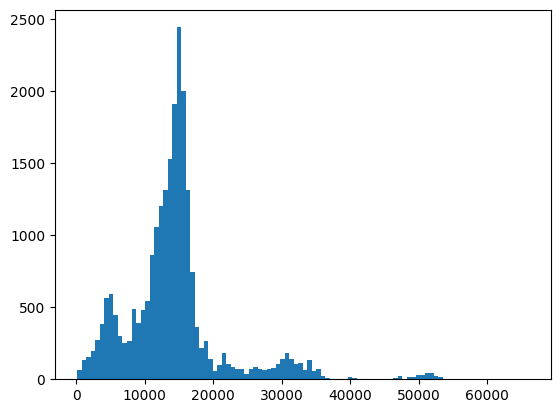

In [89]:
plt.hist(data["cityCenters_nearest"], bins=100)

Большинство недвижимости продаётся примерно в 15 киломаъ от центра города. При этом есть малая часть объявлений, расположенных на расстоянии около 50 км от центра. Учитывая наличие различных населённых пунктов в выборке и единственный центр города - центр Санкт-Петербугра, делаем вывод, что это не выбросы, а особенность данных.

Рассмотрим рассперделдение до ближайшего парка `parks_nearest`.

(array([1.010e+02, 1.740e+02, 1.320e+02, 1.750e+02, 2.240e+02, 3.100e+02,
        2.860e+02, 3.000e+02, 3.020e+02, 3.280e+02, 3.250e+02, 3.840e+02,
        4.110e+02, 4.610e+02, 4.420e+02, 5.160e+02, 1.479e+03, 2.432e+03,
        1.773e+03, 2.384e+03, 3.140e+03, 2.896e+03, 1.952e+03, 1.124e+03,
        4.800e+02, 2.700e+02, 1.470e+02, 6.500e+01, 4.100e+01, 4.400e+01,
        4.100e+01, 1.400e+01, 2.300e+01, 2.100e+01, 1.500e+01, 1.000e+01,
        2.000e+00, 2.700e+01, 7.000e+00, 3.400e+01, 5.000e+00, 1.100e+01,
        9.000e+00, 2.000e+00, 9.000e+00, 1.000e+00, 1.500e+01, 1.700e+01,
        1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 1.000e+01, 6.000e+00, 0.000e+00, 0.000e+00, 5.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 4.000e+00, 2.000e+00, 3.000e+01,
        7.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 9.000e+00, 2.300e+01,
        0.000e+00, 1.000e+00, 0.000e+00, 8.000e+00, 1.000e+00, 7.000e+00,
        1.000e+00, 1.000e+00, 1.000e+0

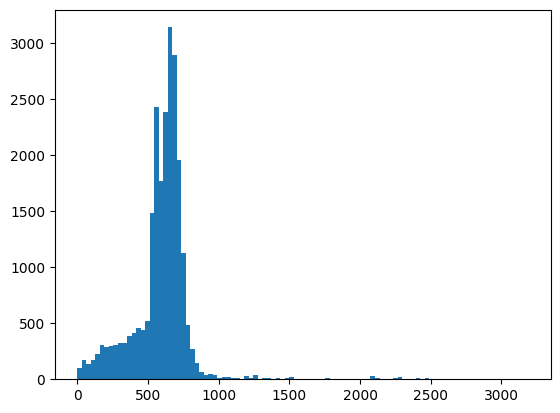

In [90]:
plt.hist(data["parks_nearest"], bins=100)

Распределение имеет длинных хвост схожий с наличием выбросов после 1500 метров. Проверим, какая часть данных сильно выделяется.

In [91]:
print(f"Выбросы по расстоянию до парка в процентах: {100 * len(data[data['parks_nearest'] > 1500]['parks_nearest']) / len(data):.2f}")

Выбросы по расстоянию до парка в процентах: 0.73


Учитывая количество значений расстояния до парка более 1.5 километров будем считать подобные расстояния выбросами и избавимся от них.

In [92]:
data = data[data['parks_nearest'] <= 1500]['parks_nearest']

Проанализируем, насколько много данных потеряно после отсечения выбросов в основных атрибутах выборки.

In [107]:
print(f"Процент утраченных после чистки записей: {100 - 100 * len(data) / rows_before_purge:.2f}%")

Процент утраченных после чистки записей: 1.50%


Количество потерь невелико, а качество данных улучшилось засчёт устранения выбросов.

### Напишите общий вывод

**Чек-лист готовности проекта**

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Файл с данными открыт.
- [ ]  Файл с данными изучен: выведены первые строки, использован метод `info()`, построены гистограммы.
- [ ]  Найдены пропущенные значения.
- [ ]  Пропущенные значения заполнены там, где это возможно.
- [ ]  Объяснено, какие пропущенные значения обнаружены.
- [ ]  В каждом столбце установлен корректный тип данных.
- [ ]  Объяснено, в каких столбцах изменён тип данных и почему.
- [ ]  Устранены неявные дубликаты в названиях населённых пунктов.
- [ ]  Обработаны редкие и выбивающиеся значения (аномалии).
- [ ]  В таблицу добавлены новые параметры:
       – цена одного квадратного метра;
       – день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
       – месяц публикации объявления;
       – год публикации объявления;
       – тип этажа квартиры (значения — «первый», «последний», «другой»);
       – расстояние до центра города в километрах.
- [ ]  Изучены и описаны параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего парка.
- [ ]  Выполнено задание «Изучите, как быстро продавались квартиры (столбец `days_exposition`)»:
    - построена гистограмма;
    - рассчитаны среднее и медиана;
    - описано, сколько обычно занимает продажа и указано, какие продажи можно считать быстрыми, а какие — необычно долгими.
- [ ]  Выполнено задание «Определите факторы, которые больше всего влияют на общую (полную) стоимость объекта». Построены графики, которые показывают зависимость цены от параметров:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - количество комнат;
        - тип этажа, на котором расположена квартира (первый, последний, другой);
        - дата размещения (день недели, месяц, год).
- [ ]  Выполнено задание «Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений»:
    - выделены населённые пункты с самой высокой и низкой стоимостью квадратного метра.
- [ ]  Выполнено задание «Выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите их среднюю стоимость на разном удалении от центра»:
    -  учтён каждый километр расстояния, известны средние цены квартир в одном километре от центра, в двух и так далее;
    -  описано, как стоимость объекта зависит от расстояния до центра города;
    -  построен график изменения средней цены для каждого километра от центра Петербурга.
- [ ]  На каждом этапе сделаны промежуточные выводы.
- [ ]  В конце проекта сделан общий вывод.